<a href="https://colab.research.google.com/github/samirp92/Final-Year-Project-Time-Series-Forecasting-/blob/main/XGboost_Ele_Power_Consumption_Forecasting_Student_ID_21072112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required libraries

In [ ]:
# Disable warnings in the notebook for maintaining clean output
import warnings
warnings.filterwarnings('ignore')

# Import the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Set the root path directory
root_path = "/content/drive/MyDrive/Final Year Project"

Mounted at /content/drive


# Data Loading

In [ ]:
# Load the data from google drive
df = pd.read_csv("/content/drive/MyDrive/Final Year Project/household_power_consumption.txt", sep=';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
# Display DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


# Data Preprocessing

In [ ]:
# Replace '?' with NaN values
df.replace('?', np.nan, inplace=True)

In [ ]:
# Convert numeric columns to appropriate data types
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df['Global_reactive_power'] = pd.to_numeric(df['Global_reactive_power'], errors='coerce')
df['Voltage'] = pd.to_numeric(df['Voltage'], errors='coerce')
df['Global_intensity'] = pd.to_numeric(df['Global_intensity'], errors='coerce')
df['Sub_metering_1'] = pd.to_numeric(df['Sub_metering_1'], errors='coerce')
df['Sub_metering_2'] = pd.to_numeric(df['Sub_metering_2'], errors='coerce')

# Confirm the updated data types
print(df.dtypes)

Date                      object
Time                      object
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object


In [ ]:
# Convert the 'Date' and 'Time' columns to a single 'date_time' column
df['date_time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Convert the 'date_time' column to datetime format
df['date_time'] = pd.to_datetime(df['date_time'])

# Set the 'date_time' column as the index
df.set_index('date_time', inplace=True)

# Drop the original 'Date' and 'Time' columns
df.drop(columns=['Date', 'Time'], inplace=True)

# Data Imputation

In [ ]:
# Check Missing Values
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [ ]:
# Fill NaN values using the mean for each column
df.fillna(df.mean(), inplace=True)

Note:-

(Global_active_power*1000/60 - Sub_metering_1 - Sub_metering_2 - Sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3

In [ ]:
# Creating new variable for remaining power consumption in watt hour
equation1 = (df['Global_active_power']*1000/60)
equation2 = df['Sub_metering_1'] + df['Sub_metering_2'] + df['Sub_metering_3']
df['Sub_metering_4'] = equation1 - equation2
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
date_time,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000


# EDA

Text(0.5, 1.0, 'Correlation Matrix')

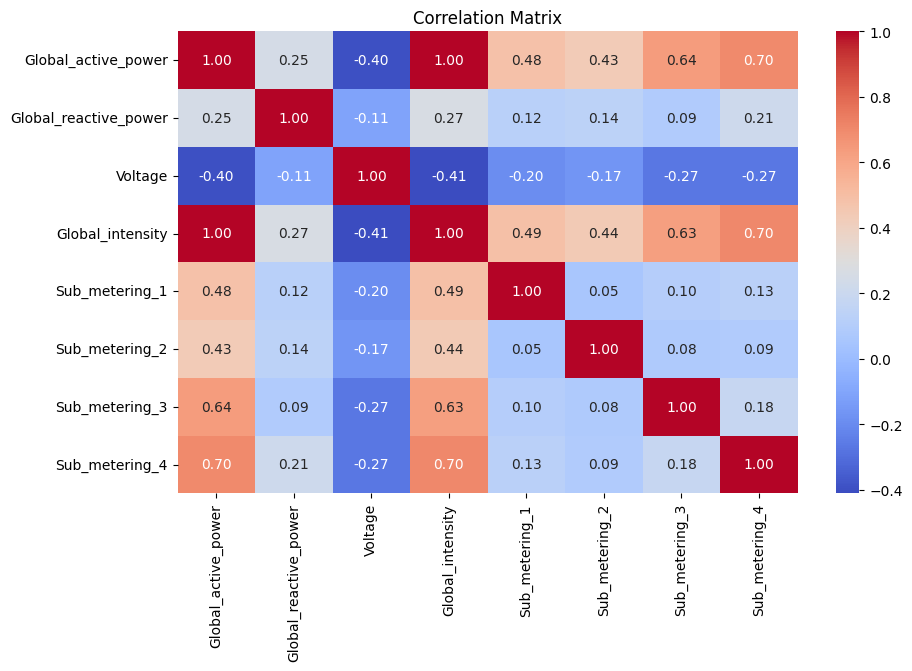

In [ ]:
# Plot the heatmap for Correlation
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
#plt.gcf().set_dpi(200)

Note:- As Global_intensity is highly correlated with Global_active_power so I am removing Global_intensity column

In [ ]:
df = df.drop(['Global_intensity', 'Sub_metering_4'], axis=1)

# Feature Engineering

In [ ]:
# Create new columns for minute, hour, day, quarter, month, and year
df['minute'] = df.index.minute
df['hour'] = df.index.hour
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['week_of_year'] = df.index.isocalendar().week
df['day_of_week'] = df.index.dayofweek
df['day_of_month'] = df.index.day
df['day_of_year'] = df.index.dayofyear
df.head()

,Global_active_power,Global_reactive_power,Voltage,Sub_metering_1,Sub_metering_2,Sub_metering_3,minute,hour,month,quarter,year,week_of_year,day_of_week,day_of_month,day_of_year
date_time,,,,,,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,0.0,1.0,17.0,24,17,12,4,2006,50,5,16,350
2006-12-16 17:25:00,5.360,0.436,233.63,0.0,1.0,16.0,25,17,12,4,2006,50,5,16,350
2006-12-16 17:26:00,5.374,0.498,233.29,0.0,2.0,17.0,26,17,12,4,2006,50,5,16,350
2006-12-16 17:27:00,5.388,0.502,233.74,0.0,1.0,17.0,27,17,12,4,2006,50,5,16,350
2006-12-16 17:28:00,3.666,0.528,235.68,0.0,1.0,17.0,28,17,12,4,2006,50,5,16,350


In [ ]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'minute', 'hour',
       'month', 'quarter', 'year', 'week_of_year', 'day_of_week',
       'day_of_month', 'day_of_year'],
      dtype='object')

# Train-Test Splitting

In [ ]:
# Split the data into Train & Test Split
features = ['Global_reactive_power', 'Voltage', 'Sub_metering_1', 'Sub_metering_2',
            'Sub_metering_3', 'minute', 'hour', 'month', 'quarter',
            'year', 'week_of_year', 'day_of_week', 'day_of_month', 'day_of_year']
target = ['Global_active_power']

train_size = int(len(df) * 0.80)
df_train = df[:train_size]
df_test = df[train_size:]

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

# Check the shape of Train & Test Split
X_train.shape,y_train.shape, X_test.shape, y_test.shape

((1660207, 14), (1660207, 1), (415052, 14), (415052, 1))

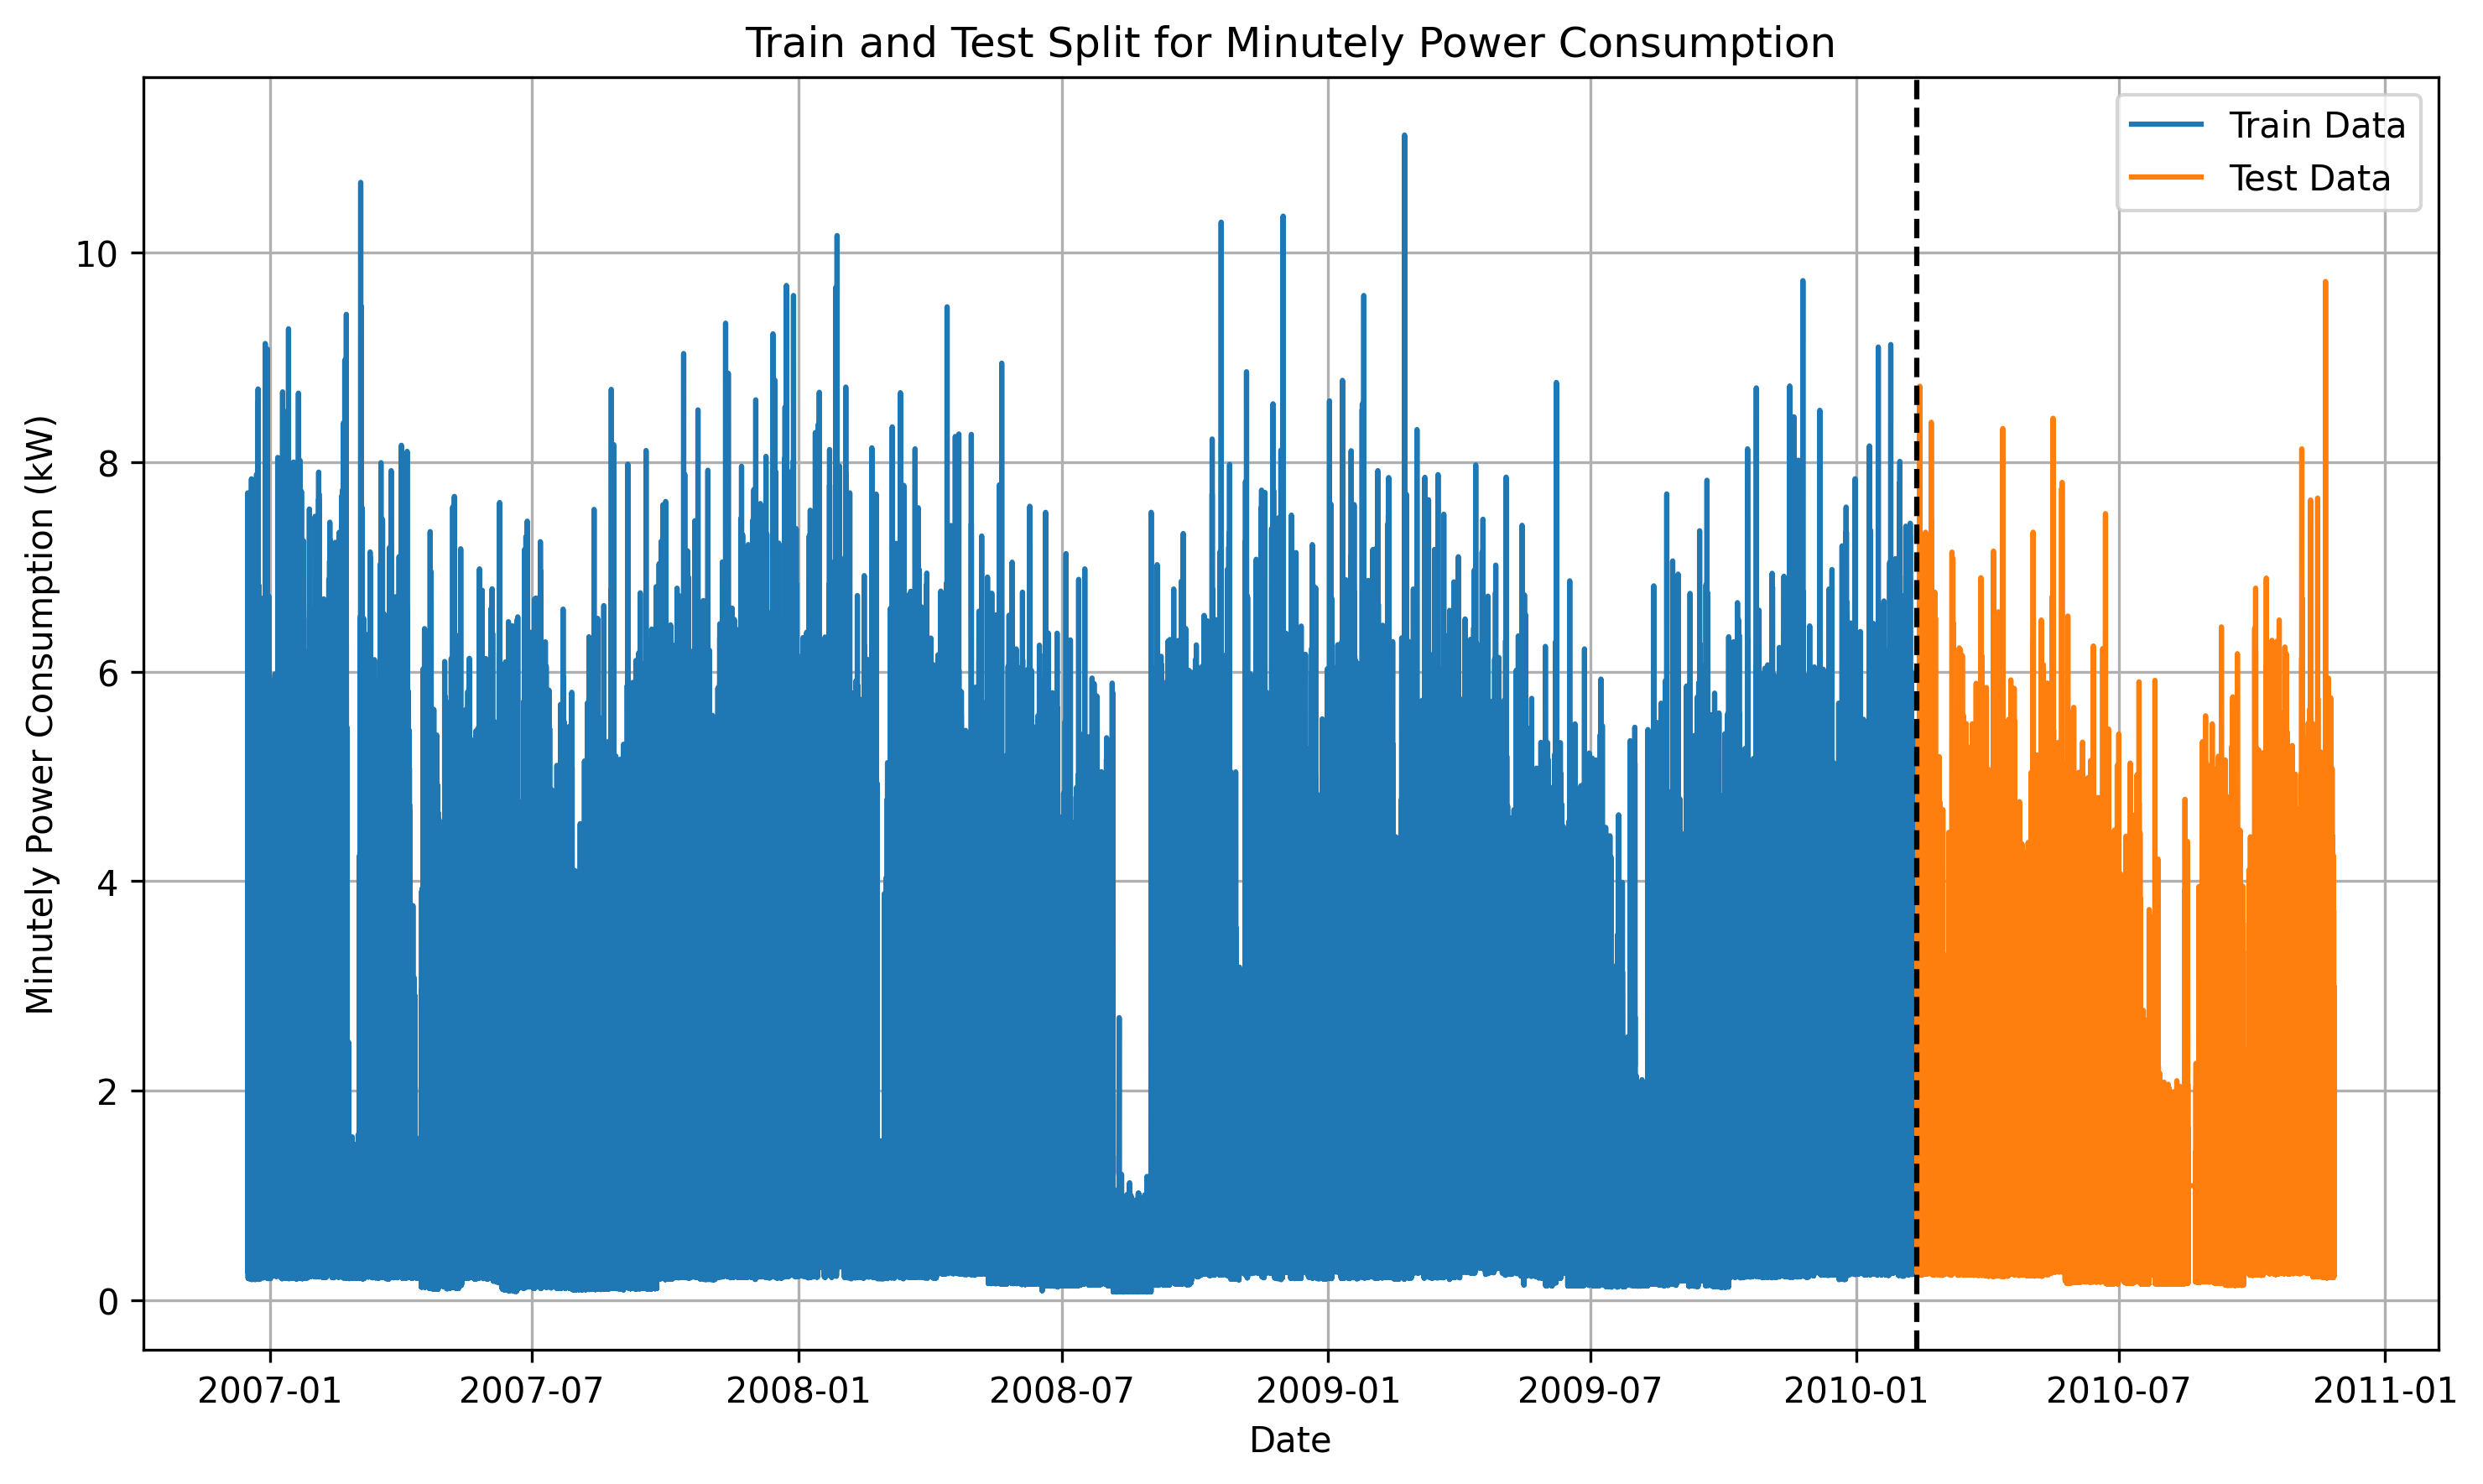

In [ ]:
# Plot train & test data
plt.figure(figsize=(10, 6), dpi=300)
plt.plot(df_train.Global_active_power, label='Train Data')
plt.plot(df_test.Global_active_power, label='Test Data')
plt.axvline(df_test.index[0], color='black', linestyle='--')
plt.title('Train and Test Split for Minutely Power Consumption')
plt.xlabel('Date')
plt.ylabel('Minutely Power Consumption (kW)')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

# Xgboost model

In [ ]:
model = xgb.XGBRegressor()
history = model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:0.84879	validation_1-rmse:0.65756
[99]	validation_0-rmse:0.34082	validation_1-rmse:0.32635


In [ ]:
# Predictions with the model
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, train_predict))
print('Train Mean Squared Error:', mean_squared_error(y_train, train_predict))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, train_predict)))
print('\nTest Mean Absolute Error:', mean_absolute_error(y_test, test_predict))
print('Test Mean Squared Error:', mean_squared_error(y_test, test_predict))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, test_predict)))

Train Mean Absolute Error: 0.20298852071390946
Train Mean Squared Error: 0.11616088160970528
Train Root Mean Squared Error: 0.34082382781974807

Test Mean Absolute Error: 0.20677175931666697
Test Mean Squared Error: 0.1065018016209676
Test Root Mean Squared Error: 0.32634613774483007


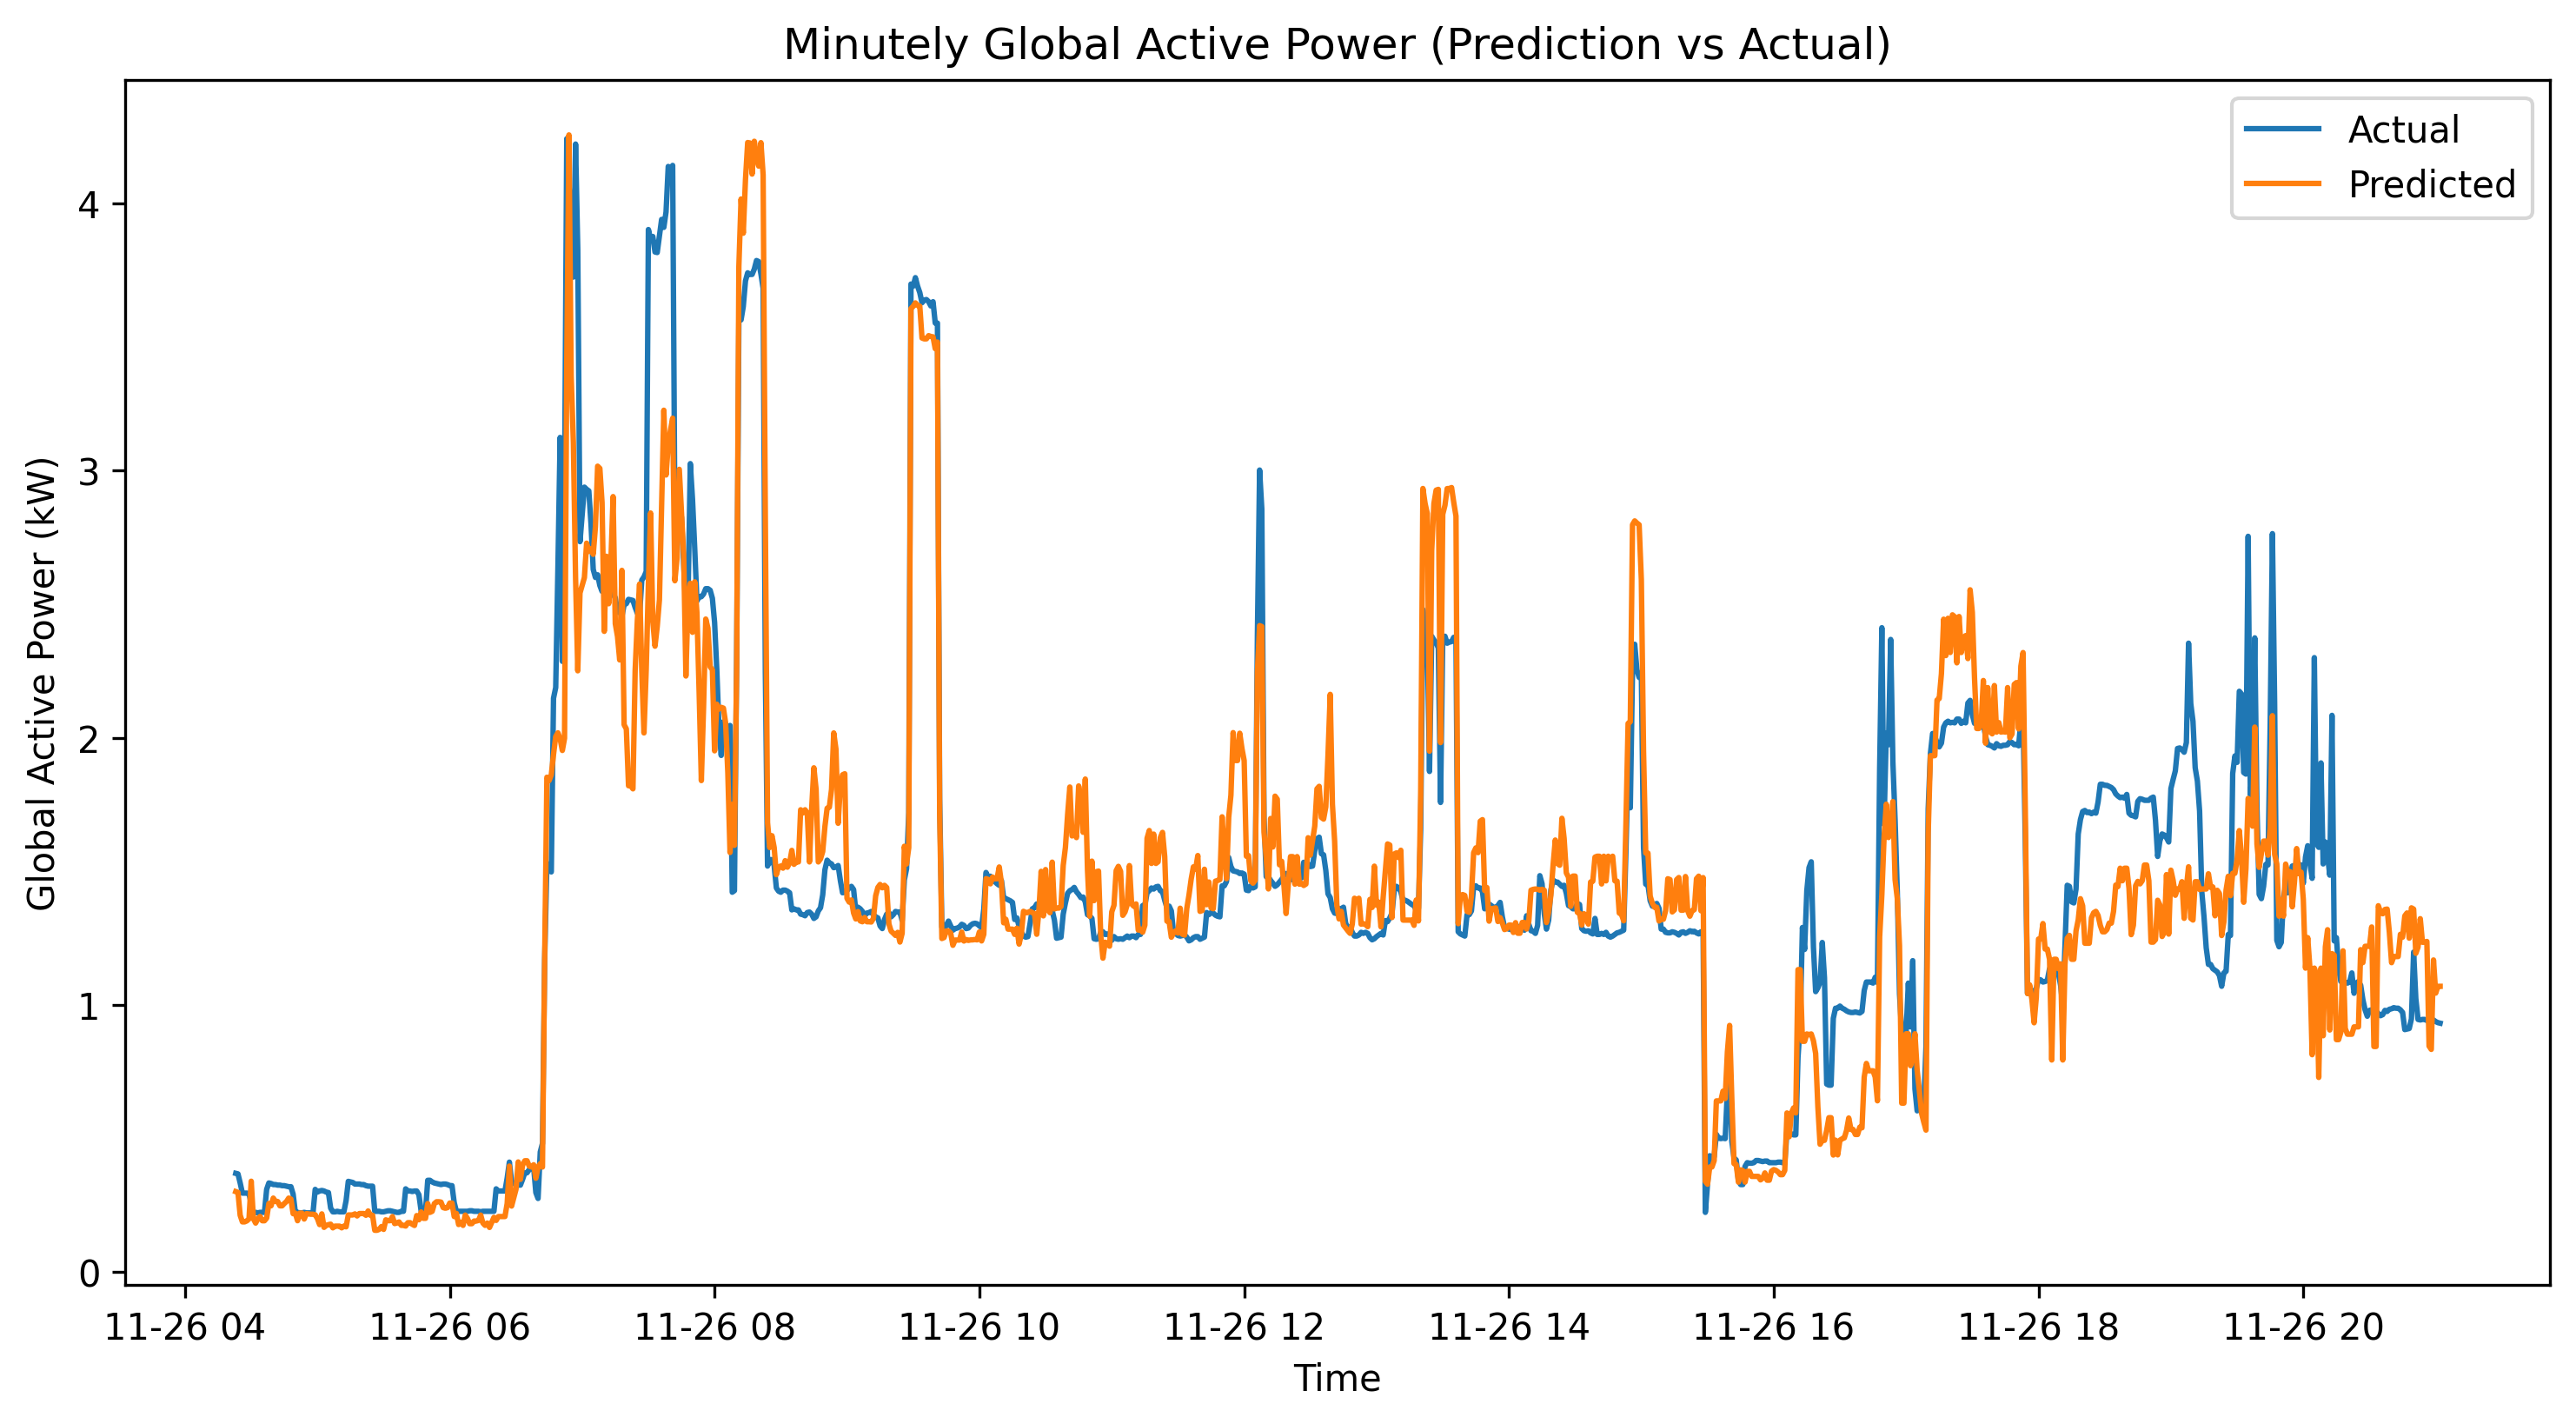

In [ ]:
# Plot the graph Actual vs Prediction
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(df.index[-1000:], y_test[-1000:], label='Actual')
plt.plot(df.index[-1000:], test_predict[-1000:], label='Predicted')
plt.title('Minutely Global Active Power (Prediction vs Actual)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

# Grid Search for optimal hyperparameters

In [ ]:
# Define the XGBoost model
model = xgb.XGBRegressor(tree_method='gpu_hist')

# Define the parameters
parameters_grid = {
    'base_score' : [0.2, 0.3],
    'n_estimators' : [1000, 1500, 2000],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma' : [0, 2],
    'max_depth' : [2, 6, 7],
    'min_child_weight' : [1, 2],
    'subsample' : [0.5, 0.7],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'booster' : ['gbtree'],
    'reg_lambda': [1, 2, 3],
    'reg_alpha' : [0, 1, 3]
    }

In [ ]:
# Set up Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=parameters_grid,
                           scoring='neg_mean_squared_error', cv=7)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

In [ ]:
# Evaluate the model on the test set
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Mean squared error on test set: ", mse)
print("Mean absolute error on test set: ", mae)

# Predictions with optimal hyperparameters
df_train['prediction'] = grid_search.best_estimator_.predict(X_train)
df_test['prediction'] = grid_search.best_estimator_.predict(X_test)

print('Train Mean Absolute Error:', mean_absolute_error(y_train, df_train.prediction))
print('Train Mean Squared Error:', mean_squared_error(y_train, df_train.prediction))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(y_train, df_train.prediction)))

print('Test Mean Absolute Error:', mean_absolute_error(y_test, df_test.prediction))
print('Test Mean Squared Error:', mean_squared_error(y_test, df_test.prediction))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(y_test, df_test.prediction)))